<a href="https://colab.research.google.com/github/andrewm4894/colabs/blob/master/time_sereis_anomaly_detection_with_pca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)

In [19]:
#!pip install netdata_pandas

In [3]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

from netdata_pandas.data import get_data


def anomaly_scores(pca, X):
    """Given a fitted pca model and some X feature vectors, compute an anomaly score as the sum of weighted euclidean distance between each sample to the
    hyperplane constructed by the selected eigenvectors. 
    """
    return np.sum(cdist(X, pca.components_) / pca.explained_variance_ratio_, axis=1).ravel()


def preprocess_df(df, lags_n, diffs_n, smooth_n, diffs_abs=False, abs_features=True):
    """Given a pandas dataframe preprocess it to take differences, add smoothing, and lags as specified. 
    """
    if diffs_n >= 1:
        # take differences
        df = df.diff(diffs_n).dropna()
        # abs diffs if defined
        if diffs_abs == True:
            df = abs(df)
    if smooth_n >= 2:
        # apply a rolling average to smooth out the data a bit
        df = df.rolling(smooth_n).mean().dropna()
    if lags_n >= 1:
        # for each dimension add a new columns for each of lags_n lags of the differenced and smoothed values for that dimension
        df_columns_new = [f'{col}_lag{n}' for n in range(lags_n+1) for col in df.columns]
        df = pd.concat([df.shift(n) for n in range(lags_n + 1)], axis=1).dropna()
        df.columns = df_columns_new
    # sort columns to have lagged values next to each other for clarity when looking at the feature vectors
    df = df.reindex(sorted(df.columns), axis=1)

    # abs all features if specified
    if abs_features == True:
        df = abs(df)
    
    return df

/usr/local/lib/python3.7/dist-packages/trio/_core/_multierror.py:464: RuntimeWarning: IPython detected, but you already have a custom exception handler installed. I'll skip installing Trio's custom handler, but this means MultiErrors will not show full tracebacks.
  category=RuntimeWarning,


In [4]:
host = 'london.my-netdata.io'
after = -3600
before = 0
dims = ['system.cpu|system']
charts = list(set([d.split('|')[0] for d in dims]))

n_train = 3000
diffs_n = 1
lags_n = 3
smooth_n = 3

(3600, 1)


,system.cpu|system
time_idx,
2021-10-11 12:31:34,1.511335
2021-10-11 12:31:35,0.502513
2021-10-11 12:31:36,0.753769
2021-10-11 12:31:37,1.246883
2021-10-11 12:31:38,0.506329


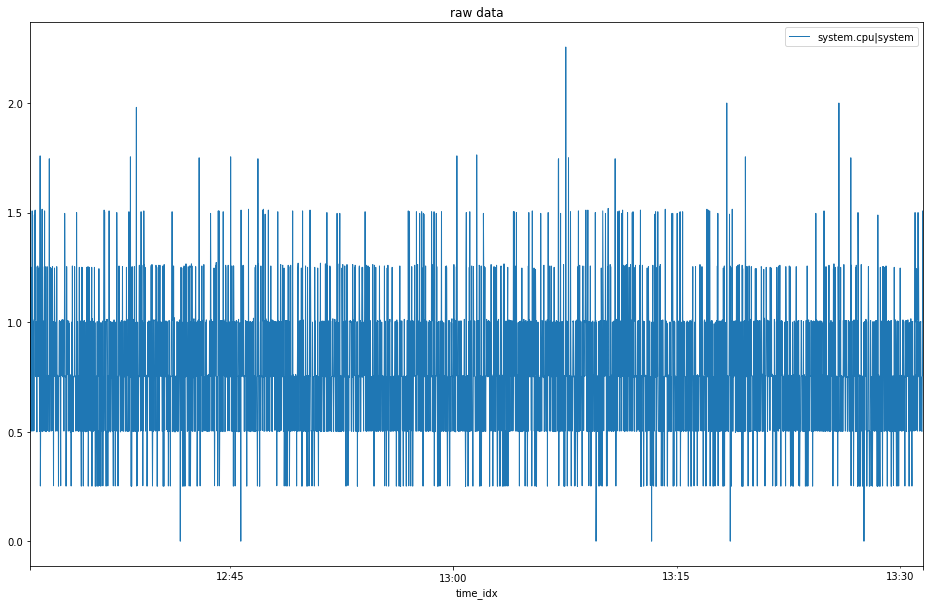

In [10]:
df = get_data(hosts=[host], charts=charts, after=after, before=before, index_as_datetime=True)
df = df[dims]
print(df.shape)
display(df.head())

df.plot(title='raw data', figsize=(16,10), lw=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3076: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3041: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

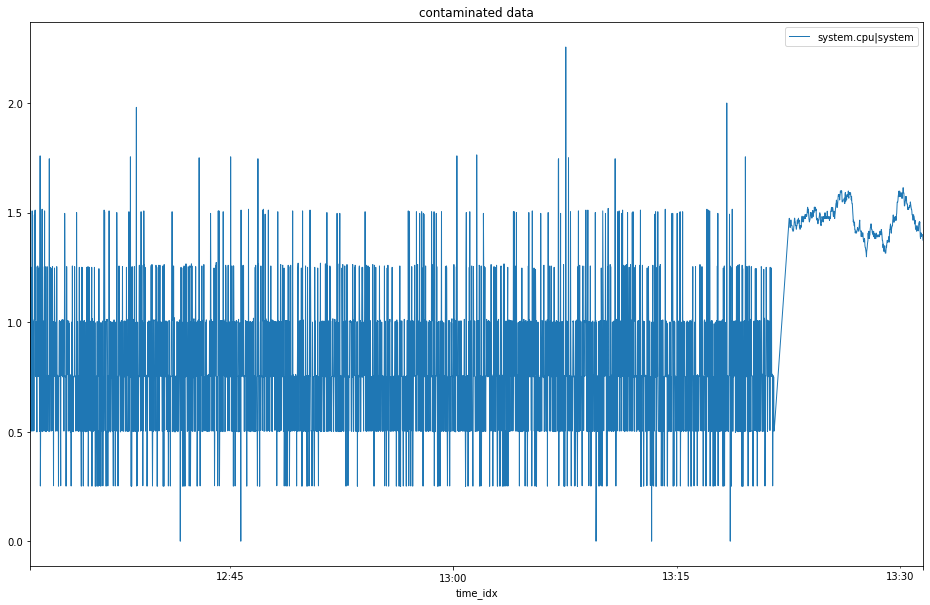

In [15]:
# create train data
df_train = df.head(n_train)
train_data = preprocess_df(df_train, lags_n, diffs_n, smooth_n)

# create anomalous data
df_anomalous = df.tail(len(df) - n_train)
df_anomalous[dims] = df_anomalous.sample(frac=1).values
df_anomalous = df_anomalous.rolling(60).mean()*2
anomalous_data = preprocess_df(df_anomalous, lags_n, diffs_n, smooth_n)

# append train data and anomalous data as 'contaminated' data
df_contaminated = df_train.append(df_anomalous).interpolate(method='linear')
df_contaminated.plot(title='contaminated data', figsize=(16,10), lw=1)
contaminated_data = preprocess_df(df_contaminated, lags_n, diffs_n, smooth_n)

In [16]:
# build PCA model
pca = PCA(n_components=2)

# scale based on training data
scaler = StandardScaler()
scaler.fit(train_data)

# fit model
pca.fit(scaler.transform(train_data))

# get anomaly scores for training data
train_scores = anomaly_scores(pca, scaler.transform(train_data))
df_train_scores = pd.DataFrame(train_scores, columns=['anomaly_score'], index=train_data.index)
df_train_scores_min = df_train_scores.min()
df_train_scores_max = df_train_scores.max()

# normalize anomaly scores on based training data
df_train_scores = ( df_train_scores - df_train_scores_min ) / ( df_train_scores_max - df_train_scores_min )

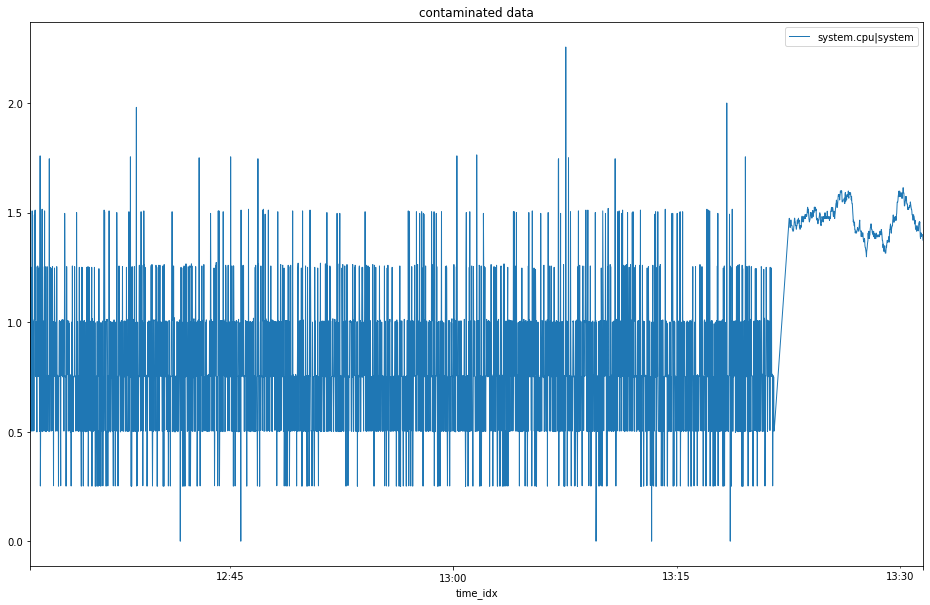

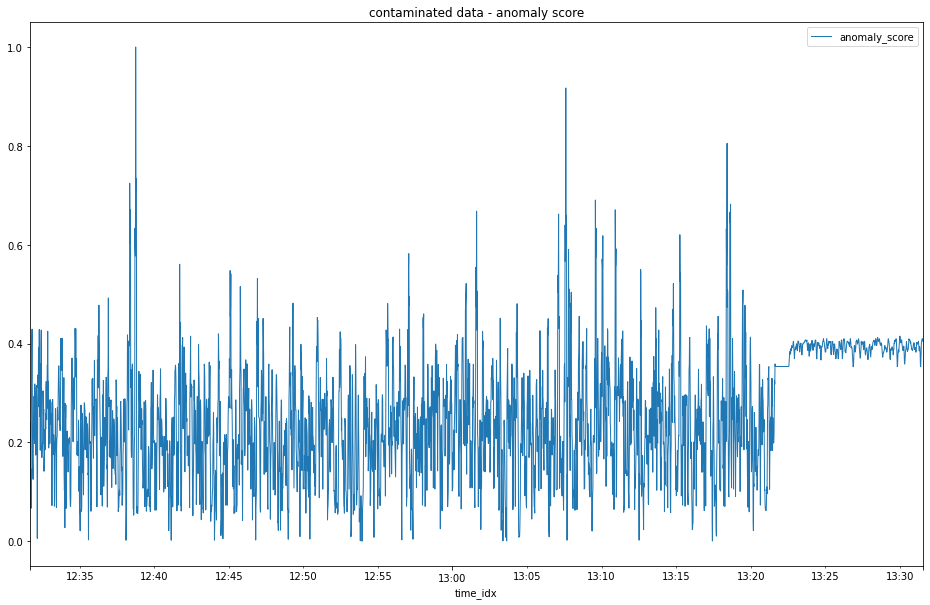

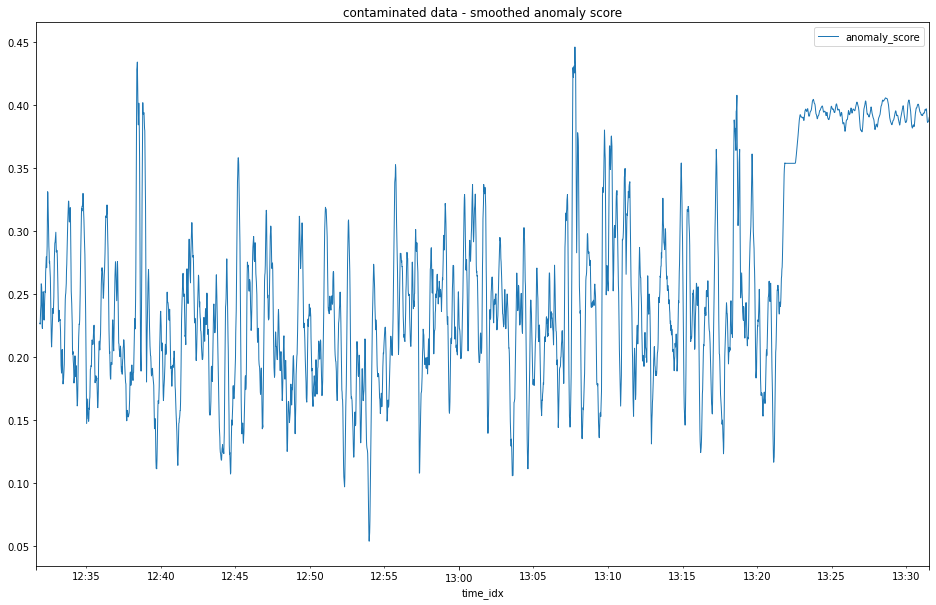

In [18]:
# score all contaminated data
contaminated_scores = anomaly_scores(pca, scaler.transform(contaminated_data))
df_contaminated_scores = pd.DataFrame(contaminated_scores, columns=['anomaly_score'], index=contaminated_data.index)

# normalize based on train data scores
df_contaminated_scores = ( df_contaminated_scores - df_train_scores_min ) / ( df_train_scores_max - df_train_scores_min )

# add rolling mean of scores to smooth more
df_contaminated_scores_smoothed = df_contaminated_scores.rolling(15).mean()

df_contaminated.plot(title='contaminated data', figsize=(16,10), lw=1)
df_contaminated_scores.plot(title='contaminated data - anomaly score', figsize=(16,10), lw=1)
df_contaminated_scores_smoothed.plot(title='contaminated data - smoothed anomaly score', figsize=(16,10), lw=1)